In [1]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
#from PDBClean import pdbclean_io, pdbutils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Summary of PDB dataset 

## what is the goal of this notebook?


This notebook creates a summary of the basic features of a structure dataset. It takes as input the 'raw_bank' directory created during steo 0. Users need to create a 'pdblist.txt' with the list of CIFs that will be included in the summary. Users also need to specify the directories where the CIFs are stored, and the directory where the created files will be stored. 

In a first step, a pandas dataframe is populated with the info read from the CIFs. The info in the dataframe is then written as a csv file. 

In a second step, we create an image with the plots summarizing the data in the dataframe. Four plots are included, a boxplot of the resolution of the structures, a histogram of the year in which the structures were published, a histogram of the methods used to solve the structures, and a histogram of the organism of origin of the molecule in the structure. The image with the four plots is saved as a pdf. 




## Define functions

In [2]:
def make_pdb_df(trajdir, readdir, trajlist):

    pdbids=[]
    orgalist=[]
    resolution=[]
    year=[]
    method=[]

    trajitas=open(trajdir+trajlist,'r')
    trajitas=trajitas.readlines()


    for item in range(0,len(trajitas)):
        pdbid=trajitas[item].strip()
        pdbid=pdbid[0:4]
        pdbids.append(pdbid)

        #pdbutils.download_pdb_from_id(oldfile, download_dir=readdir)

        mmcif_dict = MMCIF2Dict(readdir+pdbid+".cif")

        # find organism
        if '_em_entity_assembly_naturalsource.organism' in mmcif_dict:
            organism=mmcif_dict['_em_entity_assembly_naturalsource.organism'][0]
            orgalist.append(organism.upper())
        elif '_entity_src_nat.pdbx_organism_scientific' in mmcif_dict:
            organism=mmcif_dict['_entity_src_nat.pdbx_organism_scientific'][0]
            orgalist.append(organism.upper())
        elif '_entity_src_gen.pdbx_gene_src_scientific_name' in mmcif_dict:
            organism=mmcif_dict['_entity_src_gen.pdbx_gene_src_scientific_name'][0]
            orgalist.append(organism.upper())
        else:
            orgalist.append('')

        #find resolution
        if '_reflns.d_resolution_high' in mmcif_dict:
            if mmcif_dict['_reflns.d_resolution_high'][0] != '?':
                resolution.append(mmcif_dict['_reflns.d_resolution_high'][0])
            elif '_em_3d_reconstruction.resolution' in mmcif_dict and (mmcif_dict['_em_3d_reconstruction.resolution'][0] != '?'):
                resolution.append(mmcif_dict['_em_3d_reconstruction.resolution'][0])
            elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(mmcif_dict['_refine.ls_d_res_high'][0])
            else:
                resolution.append('0')
        elif '_em_3d_reconstruction.resolution' in mmcif_dict:
            if mmcif_dict['_em_3d_reconstruction.resolution'][0] != '?':
                resolution.append(mmcif_dict['_em_3d_reconstruction.resolution'][0])
            elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(mmcif_dict['_refine.ls_d_res_high'][0])
            else:
                resolution.append('0')
        elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(mmcif_dict['_refine.ls_d_res_high'][0])
        else:
            resolution.append('0')

        #find year of publication

        if '_citation.year' in mmcif_dict:
            if mmcif_dict['_citation.year'][0] == '?':
                year.append('')
            else:
                year.append(mmcif_dict['_citation.year'][0])
        else:
            year.append('')  
        
        
        #find method
        
        if '_exptl.method' in mmcif_dict:
            method.append(mmcif_dict['_exptl.method'][0])
        else:
            method.append('')
            
            
        print(pdbids[item], orgalist[item], resolution[item], year[item],method[item])


    df = pd.DataFrame(list(zip(pdbids, orgalist,resolution,year,method)),
                   columns =['PDBid', 'Organism', 'Resolution','Year','Method'])

    
    return(df)
    
    #print(oldfile, orgalist)



In [3]:
def summary_plots_pdbs(df, outdir, organism):
    '''
    df: dataframe with summary info of pdb dataset
    outdir: directory where plots will be stored'''

    f = plt.figure(figsize=(32, 48))
    gs = f.add_gridspec(2, 2)
    fs = 40

    #PLOT RESOLUTION
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(df['Resolution'])#.set(title="Resolution (Å)")
    #sns.boxplot(df[df['Resolution'].str.match('N/A')==False]['Resolution'])#.set(title="Resolution (Å)")
    #sns.histplot(df['Resolution']).set(title="Resolution (Å)")
    plt.yticks(fontsize=fs)
    plt.title('Resolution (Å)', fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    
    #PLOT YEAR
    ax = f.add_subplot(gs[0, 1])
    sortdf=df.sort_values(by="Year",ascending=True)
    plot=sns.histplot(sortdf['Year'])#.set(title="Year of Publication")
    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right")#, fontsize = 'x-small')
    plt.yticks(fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)


    print("x-axis tick locations: " + str(xtick_loc))
    
    #PLOT METHOD
    
    ax = f.add_subplot(gs[1, 0])
    
    plot = sns.histplot(df['Method'])

        # Get x-axis tick locations and labels

    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right")#, fontsize = 'x-small')
    plt.yticks(fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    
    
    #PLOT ORGANISM
    ax = f.add_subplot(gs[1, 1])
    sortdf=df['Organism'].value_counts(ascending=False).rename_axis('Organism').rename('count')
    plot = sns.barplot(x=sortdf.index, y=sortdf.values, order=sortdf.index)

        # Get x-axis tick locations and labels

    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right", fontsize = 'x-small')
    
    
    plt.subplots_adjust(bottom=0.4)
    plt.yticks(fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)


    print("x-axis tick locations: " + str(xtick_loc))


    plt.savefig(outdir+organism+"_summary_plots.pdf")


## Specify working directories

In [4]:
# #CAS9
# trajlist="./pdblist.txt"
# trajdir="/Users/fatima/Stanford/PDBClean/RNAClub/CRISPR/raw_bank/"
# readdir="/Users/fatima/Stanford/PDBClean/RNAClub/CRISPR/raw_bank/"
# outdir="/Users/fatima/Stanford/WritingPDBCleanV2/EXAMPLES/"
# org_name='cas9'


In [5]:
# #ARGONAUTE
# #raw_bank % ls | grep cif > pdblist.txt
# trajdir="/Users/fatima/Stanford/PDBClean/RNAClub/ARGO/raw_bank/"
# readdir=trajdir
# outdir="/Users/fatima/Stanford/WritingPDBCleanV2/EXAMPLES/"
# trajlist="./pdblist.txt"
# org_name='argo'

In [6]:
# TIM
# readdir='/Users/fatima/Stanford/PDBClean/TestPyPiVer/NOTEBOOKS/TestSRC/TIM_ALL/raw_bank/'
# trajdir=readdir
# trajlist="./pdblist.txt"
# outdir='/Users/fatima/Stanford/WritingPDBCleanV2/EXAMPLES/'
# org_name='tim'



In [7]:
# ACE
readdir='/Users/fatima/Stanford/Marianna/ACE/raw_bank/'
trajdir=readdir
trajlist='./pdblist.txt'
outdir='/Users/fatima/Stanford/WritingPDBCleanV2/EXAMPLES/'
org_name='ace'


## Run functions

1. Populate dataframe with basic info of each structure: 'PDBid', 'Organism', 'Resolution','Year', 'Method' 
2. Create plots with summary of the basic info. 


In [8]:
# Populate dataframe
# Funcion prints items to screen
df=make_pdb_df(trajdir, readdir, trajlist)

1acj TORPEDO CALIFORNICA 2.8 1993 X-RAY DIFFRACTION
1acl TORPEDO CALIFORNICA 2.8 1993 X-RAY DIFFRACTION
1amn TORPEDO CALIFORNICA 2.8 1996 X-RAY DIFFRACTION
1ax9 TORPEDO CALIFORNICA 2.8 1998 X-RAY DIFFRACTION
1b41 DENDROASPIS ANGUSTICEPS 2.800 2000 X-RAY DIFFRACTION
1c2b ELECTROPHORUS ELECTRICUS 4.5 1999 X-RAY DIFFRACTION
1c2o ELECTROPHORUS ELECTRICUS 4.2 1999 X-RAY DIFFRACTION
1cfj TORPEDO CALIFORNICA 2.6 1999 X-RAY DIFFRACTION
1dx6 TORPEDO CALIFORNICA 2.300 1999 X-RAY DIFFRACTION
1e3q TORPEDO CALIFORNICA 2.830 2002 X-RAY DIFFRACTION
1e66 TORPEDO CALIFORNICA 2.100 2002 X-RAY DIFFRACTION
1ea5 TORPEDO CALIFORNICA 1.800 2002 X-RAY DIFFRACTION
1eea ELECTROPHORUS ELECTRICUS 4.5 1998 X-RAY DIFFRACTION
1eve TORPEDO CALIFORNICA 2.5 1999 X-RAY DIFFRACTION
1f8u DENDROASPIS ANGUSTICEPS 2.90 2000 X-RAY DIFFRACTION
1fss TORPEDO CALIFORNICA 3.0 1995 X-RAY DIFFRACTION
1gpk TORPEDO CALIFORNICA 2.100 2002 X-RAY DIFFRACTION
1gpn TORPEDO CALIFORNICA 2.350 2002 X-RAY DIFFRACTION
1gqr TORPEDO CALIFORNICA 2

4qww BUNGARUS FASCIATUS 2.7 2015 X-RAY DIFFRACTION
4tvk TORPEDO CALIFORNICA 2.30 2014 X-RAY DIFFRACTION
4w63 TORPEDO CALIFORNICA 2.800 2016 X-RAY DIFFRACTION
4x3c TORPEDO CALIFORNICA 2.60  X-RAY DIFFRACTION
5bwb TORPEDO CALIFORNICA 2.57 2015 X-RAY DIFFRACTION
5bwc TORPEDO CALIFORNICA 2.45 2015 X-RAY DIFFRACTION
5dlp TORPEDO CALIFORNICA 2.7 2016 X-RAY DIFFRACTION
5dti MUS MUSCULUS 2.0 2015 X-RAY DIFFRACTION
5dtj MUS MUSCULUS 2.7 2015 X-RAY DIFFRACTION
5e2i TORPEDO CALIFORNICA 2.65 2016 X-RAY DIFFRACTION
5e4j TORPEDO CALIFORNICA 2.54 2016 X-RAY DIFFRACTION
5e4t TORPEDO CALIFORNICA 2.43 2016 X-RAY DIFFRACTION
5ehn MUS MUSCULUS 2.6 2016 X-RAY DIFFRACTION
5ehq MUS MUSCULUS 2.5 2016 X-RAY DIFFRACTION
5ehx TORPEDO CALIFORNICA 2.100  X-RAY DIFFRACTION
5ehz MUS MUSCULUS 2.5 2016 X-RAY DIFFRACTION
5ei5 TORPEDO CALIFORNICA 2.100  X-RAY DIFFRACTION
5eia MUS MUSCULUS 2.7 2016 X-RAY DIFFRACTION
5eie MUS MUSCULUS 2.1 2016 X-RAY DIFFRACTION
5eih MUS MUSCULUS 2.7 2016 X-RAY DIFFRACTION
5fkj MUS MUSCULU

In [9]:
# Write dataframe as CSV file 

df.to_csv(outdir+org_name+'.csv')

x-axis tick locations: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
x-axis tick locations: [0 1 2 3 4 5 6 7 8 9]


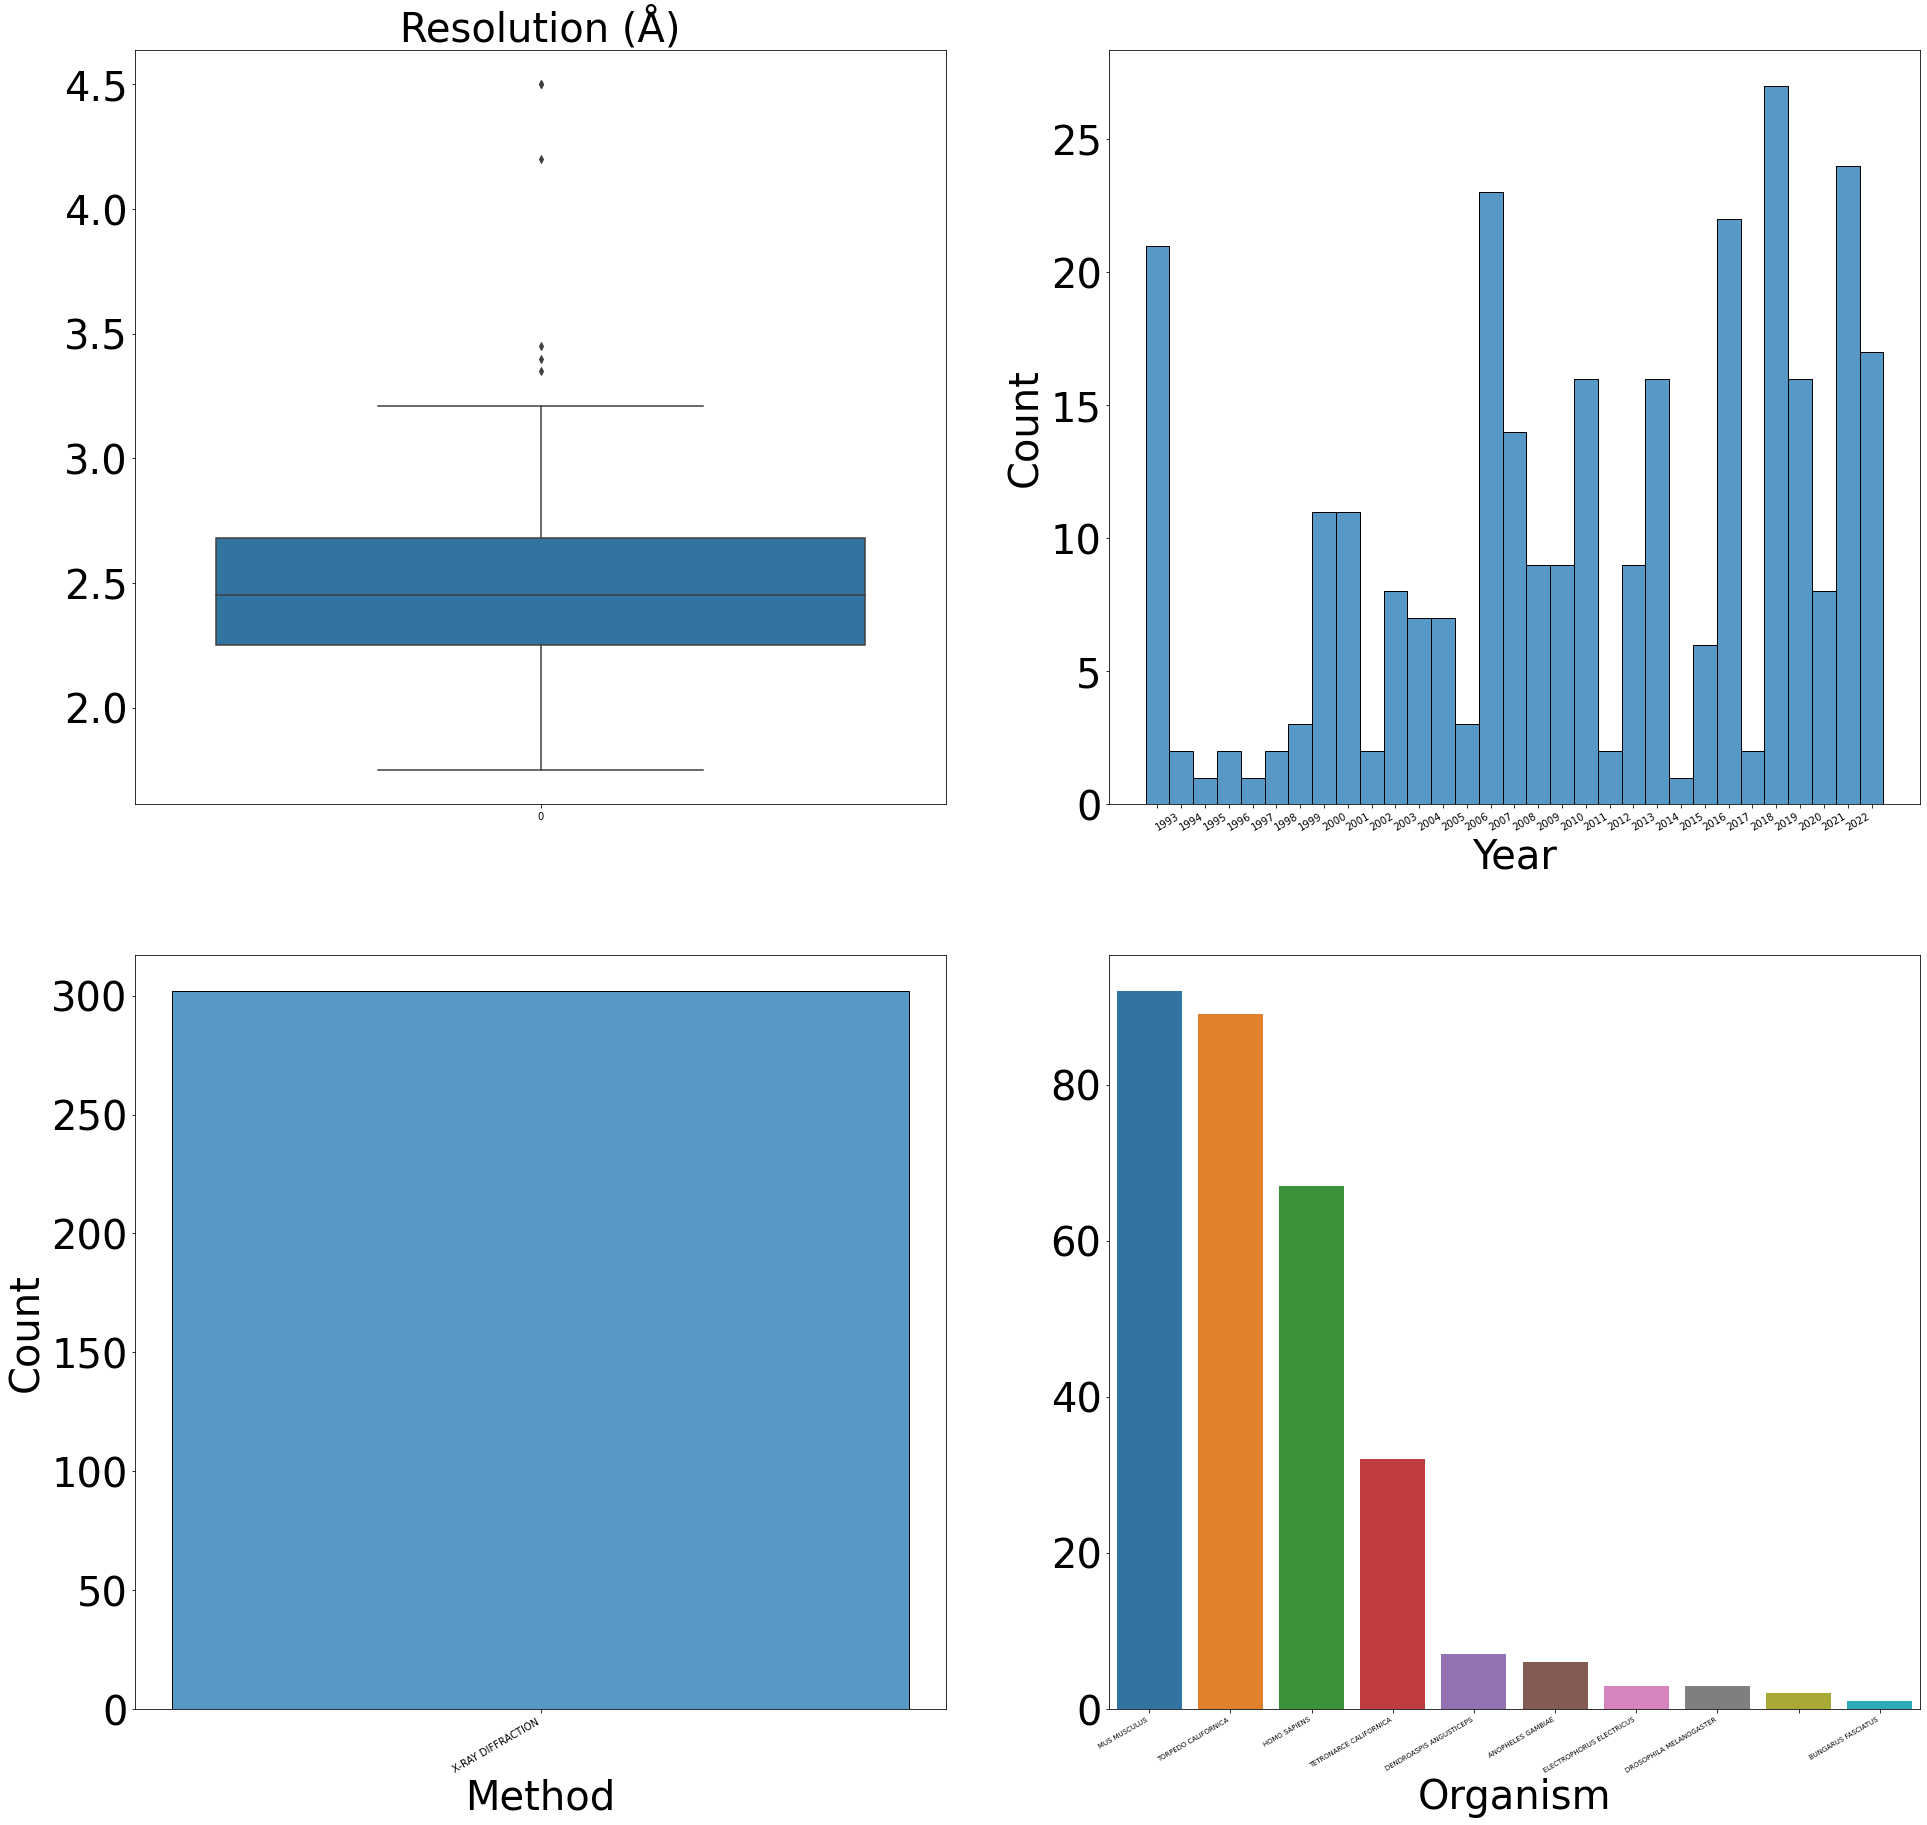

In [10]:
# Create images with the plots summarizing the info in the dataframe

summary_plots_pdbs(df, outdir,org_name)